In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb

In [2]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(self.annotations['dx'].unique())}
        self.inverse_mapping = {v: k for k, v in self.label_mapping.items()}
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations.iloc[idx]['image_id']
        label_str = self.annotations.iloc[idx]['dx']
        label = self.label_mapping[label_str]

        for dir_path in self.img_dirs:
            img_path = os.path.join(dir_path, img_id + ".jpg")
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break
        else:
            raise FileNotFoundError(f"Image {img_id}.jpg not found.")

        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random


sns.set(style="whitegrid")
csv_path = r"D:\download\archive DS50\HAM10000_metadata.csv"
df = pd.read_csv(csv_path)

print("data overview：")
print(df.head())
print("\nLabel Type：", df['dx'].unique())
print("\nNumber of labels：\n", df['dx'].value_counts())

data overview：
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Label Type： ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Number of labels：
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [4]:
df.shape

(10015, 7)

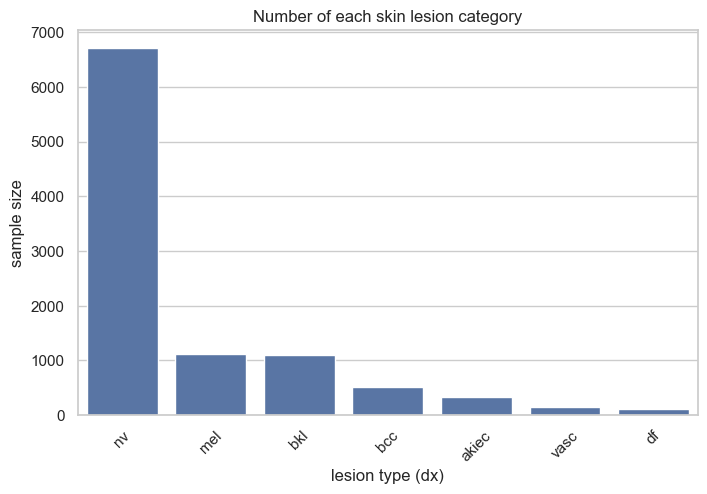

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='dx', data=df, order=df['dx'].value_counts().index)
plt.title("Number of each skin lesion category")
plt.xlabel("lesion type (dx)")
plt.ylabel("sample size")
plt.xticks(rotation=45)
plt.show()

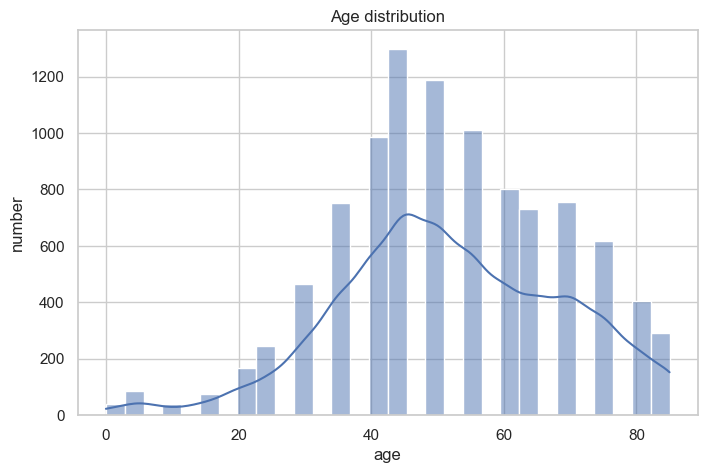

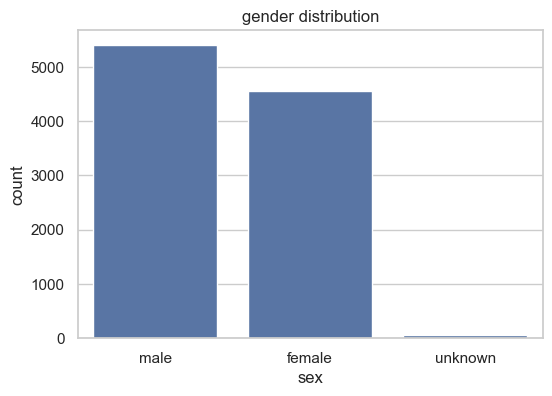

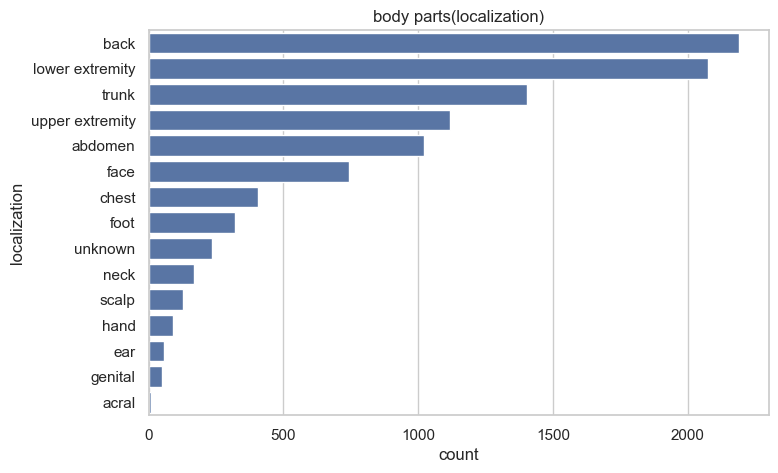

In [6]:

plt.figure(figsize=(8,5))
sns.histplot(df['age'].dropna(), bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel("age")
plt.ylabel("number")
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=df)
plt.title("gender distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.countplot(y='localization', data=df, order=df['localization'].value_counts().index)
plt.title("body parts(localization)")
plt.show()

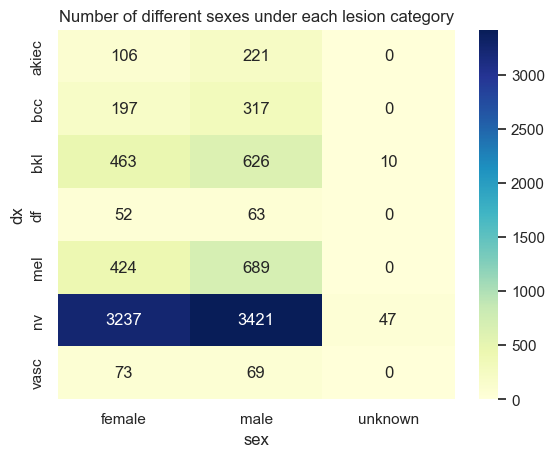

In [7]:
cross = pd.crosstab(df['dx'], df['sex'])
sns.heatmap(cross, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Number of different sexes under each lesion category")
plt.show()

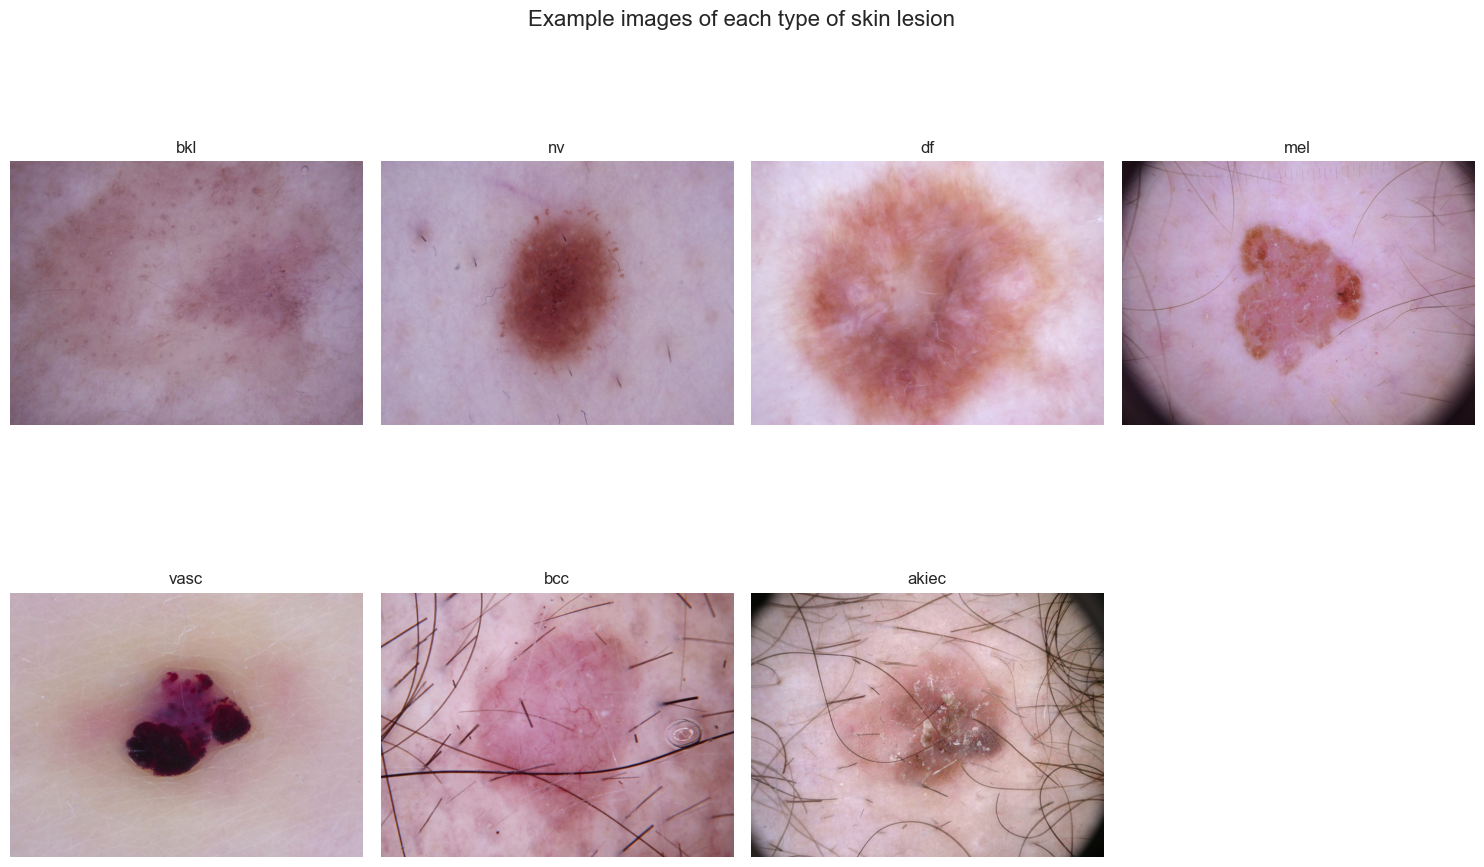

In [8]:
img_dirs = [
    r"D:\download\archive DS50\HAM10000_images_part_1",
    r"D:\download\archive DS50\HAM10000_images_part_2"
]

def find_image_path(image_id):
    for d in img_dirs:
        path = os.path.join(d, image_id + ".jpg")
        if os.path.exists(path):
            return path
    return None


unique_labels = df['dx'].unique()
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels):
    img_row = df[df['dx'] == label].sample(1).iloc[0]
    img_path = find_image_path(img_row['image_id'])
    if img_path:
        img = Image.open(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.suptitle("Example images of each type of skin lesion", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
wandb.login(key="8f54f75ecc69df541a0c38072576bc4aa5b158f4") # to be removed when uploading your solution on Moodle

wandb.init(project="DS50", name="efficientnetB0_baseline")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\123\_netrc
wandb: Currently logged in as: wenxuan-gui (wenxuan-gui-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [13]:
# =========================
# 2. data preprocessing and loading
# =========================
img_dirs = [
    r"D:\download\archive DS50\HAM10000_images_part_1",
    r"D:\download\archive DS50\HAM10000_images_part_2"
]

csv_path = r"D:\download\archive DS50\HAM10000_metadata.csv"

# Train Transform
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# Validation/Test Transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = HAM10000Dataset(csv_file=csv_path, img_dirs=img_dirs, transform=train_transform)

# train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
# =========================
# 3. define the CNN model
# =========================
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class Net(nn.Module):
    def __init__(self, num_labels):
        super(Net, self).__init__()
        #self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        #in_features = self.model.fc.in_features
        #self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        #in_features = self.model.classifier[1].in_features
        #self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        #in_features = self.model.classifier.in_features
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, num_labels)
        )
    # Defining the forward pass    
    def forward(self, inputs):
        x=self.model(inputs)
        return x 

print(f"Using device: {device}")
model = Net(num_labels = 7)
model = model.to(device)
wandb.watch(model, log="all")

Using device: cuda


In [15]:
print(model.model.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)


In [13]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # 获取标签列表（确认是训练集）
# targets = [train_dataset[i][1] for i in range(len(train_dataset))]

# # 获取唯一类别（按整数编码顺序，通常为 0~6）
# classes = np.unique(targets)

# # 自动计算平衡权重
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=targets)

# # 转为 GPU tensor，传入损失函数
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_acc = 0
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # 统计 train loss 与 acc
        with torch.no_grad():
            probs = torch.exp(output)
            top_p, top_class = probs.topk(1, dim=1)
            equals = top_class == labels.view_as(top_class)
            train_acc += equals.type(torch.float).mean().item()
            train_loss += loss.item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # ---------------- 验证阶段 ----------------
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item() * inputs.size(0)

            probs = torch.exp(output)
            top_p, top_class = probs.topk(1, dim=1)
            equals = top_class == labels.view_as(top_class)
            val_acc += equals.type(torch.float).mean().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader)

    #scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f} ({100*train_acc:.1f}%) | "
          f"Val Loss: {val_loss:.4f} ({100*val_acc:.1f}%)")

    # Log to wandb
    wandb.log({
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc
    }, step=epoch)

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_weights.pth")



Epoch 01 | LR: 0.001000 | Train Loss: 0.7113 (74.5%) | Val Loss: 0.6667 (76.4%)


KeyboardInterrupt: 

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 2. Freeze all but final layer
for param in model.model.parameters():
    param.requires_grad = False
for param in model.model.fc.parameters():
    param.requires_grad = True

# 3. Training loop
accuracyp = 0
max_iterations = 10000
log_interval = 100
iteration = 0
train_loss = 0
train_acc = 0

while iteration < max_iterations:
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        iteration += 1

        # accuracy
        with torch.no_grad():
            output_probs = torch.exp(output)  # optional if output is logits; remove if not using log-softmax
            top_p, top_class = output_probs.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            train_loss += loss.item()

        # ✅ 解冻逻辑：到2000步时解冻 layer4 和 fc
        if iteration == 2000:
            print("==> 🔓 Unfreezing layer4 and fc for fine-tuning...")
            for param in model.model.layer4.parameters():
                param.requires_grad = True
            for param in model.model.fc.parameters():
                param.requires_grad = True

        # Logging and validation
        if iteration % log_interval == 0:
            train_acc = train_acc / log_interval
            train_loss = train_loss / log_interval

            wandb.log({
                "train/loss": train_loss,
                "train/accuracy": train_acc
            }, step=iteration)

            model.eval()
            val_loss = 0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    output = model(inputs)
                    valloss = criterion(output, labels)
                    val_loss += valloss.item() * inputs.size(0)
                    output = torch.exp(output)
                    top_p, top_class = output.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            val_loss /= len(val_loader.dataset)
            val_acc = accuracy / len(val_loader)

            scheduler.step(val_loss)
            print(f"[Scheduler] Step {iteration}: Current LR = {optimizer.param_groups[0]['lr']:.6f}")

            # Save best model
            if val_acc > accuracyp:
                accuracyp = val_acc
                torch.save(model.state_dict(), "best_model_weights.pth")

            print(f"Iteration: {iteration:07d} \tTrain Loss: {train_loss:.4f} \tTrain Acc:  {100*train_acc:.2f}% \tValid Loss: {val_loss:.4f} \tValid Acc: {100*val_acc:.2f}%")
            wandb.log({
                "val/loss": val_loss,
                "val/accuracy": val_acc
            }, step=iteration)

            # Reset for next interval
            train_loss = 0
            train_acc = 0
            model.train()


[Scheduler] Step 100: Current LR = 0.001000
Iteration: 0000100 	Train Loss: 1.3349 	Train Acc:  56.75% 	Valid Loss: 1.3432 	Valid Acc: 55.14%
[Scheduler] Step 200: Current LR = 0.001000
Iteration: 0000200 	Train Loss: 1.4244 	Train Acc:  52.81% 	Valid Loss: 1.4058 	Valid Acc: 55.59%
[Scheduler] Step 300: Current LR = 0.001000
Iteration: 0000300 	Train Loss: 1.3883 	Train Acc:  52.06% 	Valid Loss: 1.3334 	Valid Acc: 54.00%
[Scheduler] Step 400: Current LR = 0.001000
Iteration: 0000400 	Train Loss: 1.3874 	Train Acc:  48.50% 	Valid Loss: 1.3532 	Valid Acc: 55.79%
[Scheduler] Step 500: Current LR = 0.001000
Iteration: 0000500 	Train Loss: 1.4598 	Train Acc:  50.31% 	Valid Loss: 1.3316 	Valid Acc: 56.93%
[Scheduler] Step 600: Current LR = 0.001000
Iteration: 0000600 	Train Loss: 1.3337 	Train Acc:  53.79% 	Valid Loss: 1.2779 	Valid Acc: 57.13%
[Scheduler] Step 700: Current LR = 0.001000
Iteration: 0000700 	Train Loss: 1.4704 	Train Acc:  52.06% 	Valid Loss: 1.3519 	Valid Acc: 54.00%
[Sched

KeyboardInterrupt: 

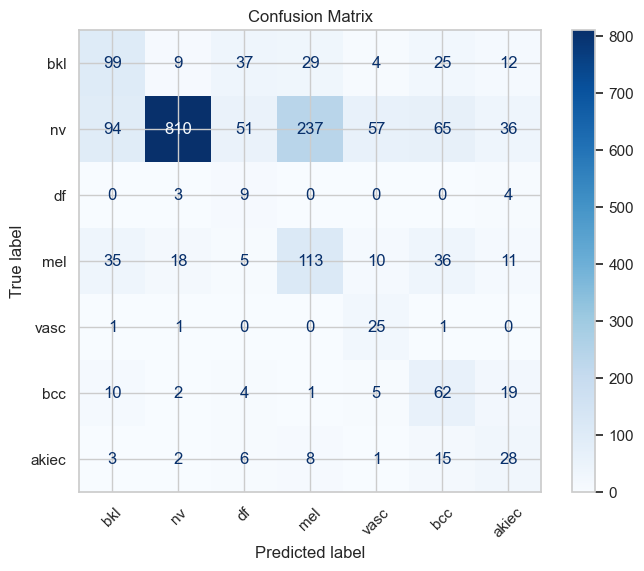

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = []
y_pred = []

model.eval()  # ✅ 正确使用实例
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

class_names = list(dataset.label_mapping.keys())  # 如果你在自定义 Dataset 类里加了这个属性

fig, ax = plt.subplots(figsize=(8, 6))  # ✅ 创建 fig
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues", ax=ax)
plt.title("Confusion Matrix")

# ✅ 上传到 wandb
wandb.log({"Confusion Matrix": wandb.Image(fig)})

plt.show()



In [52]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # shape: [batch_size, num_classes]
        probs = torch.softmax(outputs, dim=1)  # 获取概率分布

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)


In [53]:
# 获取类别总数
n_classes = y_scores.shape[1]
# One-hot 编码真实标签
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


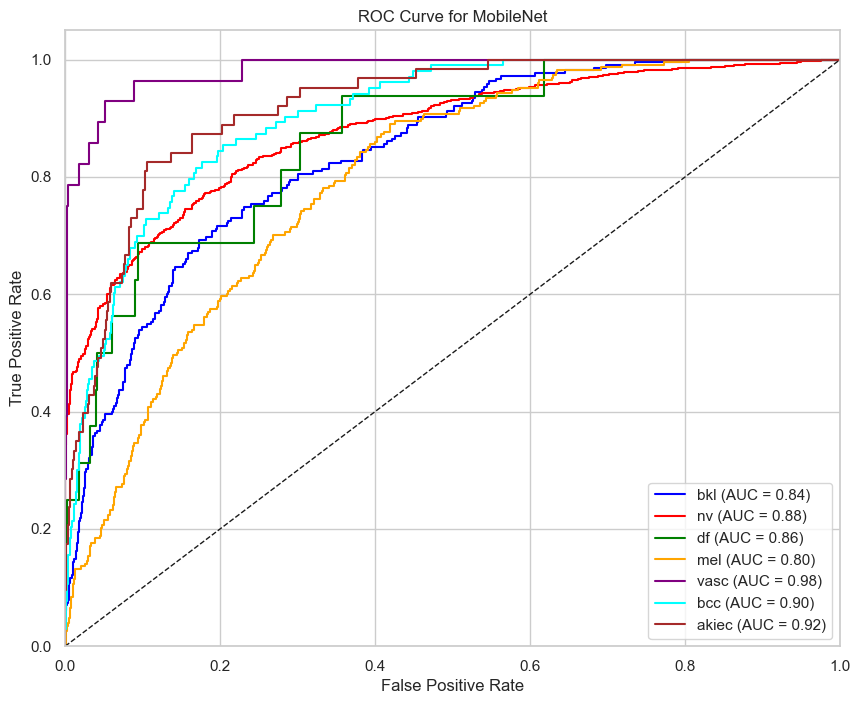

In [54]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown']
class_names = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MobileNet')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import classification_report

# 模型评估
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 获取报告字典（方便 wandb 记录）
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=True)

# 打印到控制台（可选）
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# 上传每个类的 F1 到 wandb
f1_logs = {f"f1_score/{label}": report[label]["f1-score"] for label in class_names}

# 也上传 macro 和 weighted 平均
f1_logs["f1_score/macro_avg"] = report["macro avg"]["f1-score"]
f1_logs["f1_score/weighted_avg"] = report["weighted avg"]["f1-score"]

# log 到 wandb
wandb.log(f1_logs)

wandb.finish()

              precision    recall  f1-score   support

         bkl     0.4145    0.4512    0.4321       215
          nv     0.9569    0.5926    0.7319      1350
          df     0.0917    0.6250    0.1600        16
         mel     0.3069    0.5263    0.3877       228
        vasc     0.2054    0.8214    0.3286        28
         bcc     0.2903    0.6117    0.3937       103
       akiec     0.2788    0.4603    0.3473        63

    accuracy                         0.5701      2003
   macro avg     0.3635    0.5841    0.3973      2003
weighted avg     0.7517    0.5701    0.6209      2003



f1_score/akiec,▁
f1_score/bcc,▁
f1_score/bkl,▁
f1_score/df,▁
f1_score/macro_avg,▁
f1_score/mel,▁
f1_score/nv,▁
f1_score/vasc,▁
f1_score/weighted_avg,▁
train/accuracy,▄▂▁▅▇▆▆▅█▆
train/loss,█▄▇▆▁▂▂▂▃▁


In [18]:
pip install owlready2

Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1

[notice] To update, run: python.exe -m pip install --upgrade pip

     ---------------------------------------- 0.0/27.3 MB ? eta -:--:--
     ---------------- ---------------------- 11.3/27.3 MB 76.6 MB/s eta 0:00:01


     --------------------------------------- 27.3/27.3 MB 93.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for owlready2: filename=owlready2-0.48-py3-none-any.whl size=23745529 sha256=afc7c551eb621d47278fc0315d4778ebba9fec1382fb827d9ac86d8830cbdd53
  Stored in directory: c:\users\123\appdata\local\pip\cache\wheels\aa\69\c6\665c191a5ec7d6275b19cb2877f27354a2d1cf9b23cc89bb06
Successfully built owlready2


In [21]:
# ✅ Import libraries
from owlready2 import *
import pandas as pd

# ✅ Load ontology
onto = get_ontology("dermatology.owl").load()  

# ✅ CNN label order 
class_names = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

# ✅ label -> ontology mapping
label_to_ontology_path = {
    'nv':   ['pigmentary disorder', 'disorder of hyperpigmentation', 'pigmented lesions'],
    'bkl':  ['pigmentary disorder'],
    'df':   ['disorder of neoplasm of the skin', 'benign epidermal tumor or proliferation'],
    'mel':  ['disorder of neoplasm of the skin', 'melanoma'],
    'vasc': ['vascular disorder', 'vascular birthmark'],
    'bcc':  ['disorder of neoplasm of the skin', 'non-melanoma skin cancer'],
    'akiec':['disorder of neoplasm of the skin', 'non-melanoma skin cancer']
}

# ✅ Is malignant or not
def is_malignant(label):
    return label in ['mel', 'bcc', 'akiec']

# ✅ Explian single predicted label
def explain_prediction(label):
    path = label_to_ontology_path.get(label, ["unknown"])
    malignant_flag = "⚠️ malignant" if is_malignant(label) else "✅ benign"
    return {
        "Label": label,
        "Ontology Path": " → ".join(path),
        "Malignancy": malignant_flag
    }

# ✅ Analyze a group of results
def analyze_predictions(y_pred_indices, max_display=10):
    results = []
    for i, idx in enumerate(y_pred_indices[:max_display]):
        label = class_names[idx]
        info = explain_prediction(label)
        info["Sample Index"] = i
        results.append(info)
    return results

# ✅ Output
def explain_to_dataframe(y_pred_indices, max_display=10):
    return pd.DataFrame(analyze_predictions(y_pred_indices, max_display=max_display))


In [40]:
# ✅ Owlready2 + CNN模型预测语义解释整合示例

from owlready2 import *
import pandas as pd

# Step 1: 加载 .owl 文件（请替换为你本地实际路径）
to = get_ontology("dermatology.owl").load()

# Step 2: CNN 模型输出的标签顺序（与你混淆矩阵一致）
class_names = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

# 标签 → 类名映射（字符串）
label_to_class_name = {
    'nv':   "DERMO_0000337",
    'bkl':  "DERMO_0000108",
    'df':   "DERMO_0000771",
    'mel':  "DERMO_0000970",
    'vasc': "DERMO_0001950",
    'bcc':  "DERMO_0000395",
    'akiec':"DERMO_0000395"
}

# 使用 search_one 构建真正的类对象映射
label_to_owl_class = {}
for label, cls_name in label_to_class_name.items():
    owl_class = onto.search_one(iri=f"*{cls_name}")
    label_to_owl_class[label] = owl_class

# 检查结果
for label, owl_class in label_to_owl_class.items():
    print(f"{label}: {owl_class}")

# Step 4: 判断是否属于恶性病变（动态引用 OWL 类）
mel_class = label_to_owl_class['mel']
nmsc_class = label_to_owl_class['bcc']

def is_malignant_owl(label):
    cls = label_to_owl_class[label]
    return (mel_class in cls.ancestors()) or (nmsc_class in cls.ancestors())

# Step 5: 获取语义路径（祖先类路径）
def get_owl_path(label):
    cls = label_to_owl_class[label]
    path = []
    visited = set()

    # 递归回溯路径
    def dfs(current):
        if current in visited:
            return
        visited.add(current)
        parents = list(current.is_a)
        for parent in parents:
            dfs(parent)
        # 添加当前类（如果有 label 就显示 label）
        if hasattr(current, 'label') and current.label:
            path.append(current.label[0])
        else:
            path.append(current.name)

    dfs(cls)
    return " → ".join(path)

# Step 6: 解释单个预测结果（英文 + 推荐建议）
def explain_prediction_owl(label):
    path_str = get_owl_path(label)
    is_malignant = is_malignant_owl(label)
    mal_flag = "⚠️ Malignant" if is_malignant else "✅ Benign"
    recommendation = "Seek medical attention" if is_malignant else "No immediate concern"
    return {
        "Label": label,
        "Ontology Path": path_str,
        "Malignancy": mal_flag,
        "Recommendation": recommendation
    }

# Step 7: 批量分析预测输出（y_pred 为整数索引列表）
def analyze_predictions(y_pred_indices, class_names, max_display=10):
    results = []
    for i, idx in enumerate(y_pred_indices[:max_display]):
        label = class_names[idx]
        info = explain_prediction_owl(label)
        info["Sample Index"] = i
        results.append(info)
    return pd.DataFrame(results)


nv: obo.DERMO_0000337
bkl: obo.DERMO_0000108
df: obo.DERMO_0000771
mel: obo.DERMO_0000970
vasc: obo.DERMO_0001950
bcc: obo.DERMO_0000395
akiec: obo.DERMO_0000395


In [41]:
for label, owl_class in label_to_owl_class.items():
    print(f"{label}: {owl_class}")


nv: obo.DERMO_0000337
bkl: obo.DERMO_0000108
df: obo.DERMO_0000771
mel: obo.DERMO_0000970
vasc: obo.DERMO_0001950
bcc: obo.DERMO_0000395
akiec: obo.DERMO_0000395


In [42]:

# 显示解释结果：
pd.set_option('display.max_colwidth', None)
df = explain_predictions_owl(y_pred, class_names)
display(df)


,Label,Ontology Path,Malignancy,Recommendation,Sample Index
0,bcc,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → non-melanoma skin cancer,⚠️ Malignant,Seek medical attention,0
1,nv,Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions,✅ Benign,No immediate concern,1
2,nv,Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions,✅ Benign,No immediate concern,2
3,bcc,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → non-melanoma skin cancer,⚠️ Malignant,Seek medical attention,3
4,mel,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → melanoma,⚠️ Malignant,Seek medical attention,4
5,nv,Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions,✅ Benign,No immediate concern,5
6,nv,Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions,✅ Benign,No immediate concern,6
7,mel,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → melanoma,⚠️ Malignant,Seek medical attention,7
8,nv,Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions,✅ Benign,No immediate concern,8
9,df,Thing → disease → cutaneous disease → disorder of neoplasm of the skin → benign epidermal tumor or proliferation,✅ Benign,No immediate concern,9


In [46]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_and_explain(image_path, model, device):
    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred_index = predicted.item()

    label = class_names[pred_index]
    info = explain_prediction_owl(label)

    # 可视化输出
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {label}\n{info['Malignancy']} | {info['Recommendation']}", fontsize=12)
    plt.show()

    # 同时打印语义路径
    print("🔎 Ontology Path:")
    print(info['Ontology Path'])
    
    return info


C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


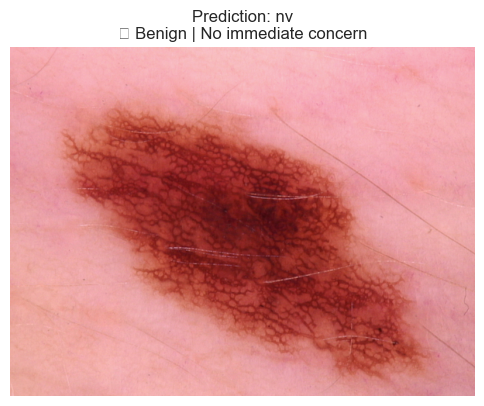

🔎 Ontology Path:
Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions


{'Label': 'nv',
 'Ontology Path': 'Thing → disease → cutaneous disease → pigmentary disorder → disorder of hyperpigmentation → pigmented lesions',
 'Malignancy': '✅ Benign',
 'Recommendation': 'No immediate concern'}

In [47]:

predict_and_explain("test.jpg", model, device)


In [48]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# 加载预训练模型（ResNet18）
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # 去除最后的全连接层
resnet.eval().cuda()  # 如果你有 GPU

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# 准备图像路径和标签列表
img_paths = []
labels = []
for i in range(len(dataset)):  # dataset 是你之前定义的 HAM10000Dataset
    img_paths.append(dataset.annotations.iloc[i]['image_id'])
    labels.append(dataset.annotations.iloc[i]['dx'])

# 提取特征
features = []
valid_labels = []
for i in tqdm(range(len(dataset))):
    image, label = dataset[i]
    image = image.unsqueeze(0).cuda()
    with torch.no_grad():
        feat = resnet(image).cpu().view(-1).numpy()
    features.append(feat)
    valid_labels.append(label)

features = np.vstack(features)  # shape: (N_samples, 512)
labels = np.array(valid_labels)


100%|███████████████████████████████████████████████████████████████████████████| 10015/10015 [01:36<00:00, 104.21it/s]


In [50]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 降维
pca = PCA(n_components=100)
X_pca = pca.fit_transform(features)

# 拆分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42, stratify=labels)

# 训练 RandomForest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# 测试结果
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\123\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

           0       0.64      0.16      0.26       220
           1       0.70      1.00      0.82      1341
           2       0.00      0.00      0.00        23
           3       0.67      0.08      0.14       223
           4       0.00      0.00      0.00        28
           5       0.88      0.07      0.13       103
           6       0.50      0.02      0.03        65

    accuracy                           0.70      2003
   macro avg       0.48      0.19      0.20      2003
weighted avg       0.67      0.70      0.60      2003



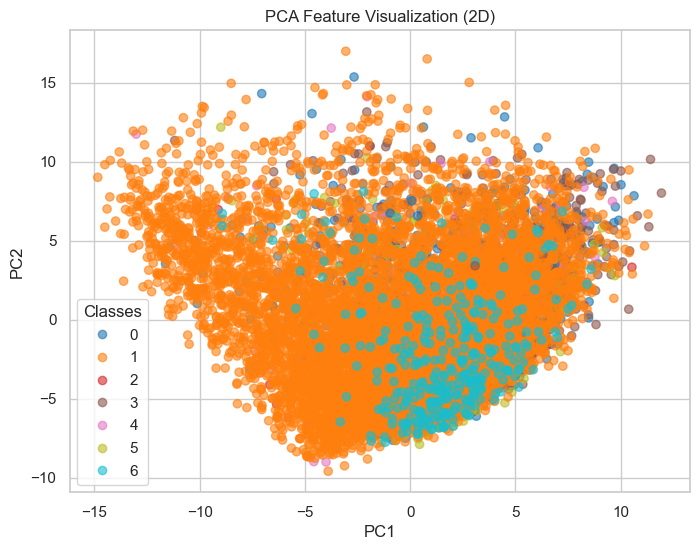

In [51]:
import matplotlib.pyplot as plt

X_vis = X_pca[:, :2]  # 前两个主成分
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.title("PCA Feature Visualization (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()
